Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` (you should of course delete `raise NotImplementedError()` which is there only as reminder), while not modifying the other cells (but you should run them to check the output you obtain). Please also fill in your group number, your full names, and your VU IDs below:

In [1]:
STUDENT_FIRST_NAME = "Thu Trang" # e.g. "John" (no "J", no "J.", no "John S.M.")
STUDENT_LAST_NAME = "Luu"  # e.g. "Smith"
VU_ID_NUM = "2695303"          # e.g. "2789012"

---

# Assignment 3
The goal of this assignment is to make you familiar with feature engineering, statistical data analysis and machine learning in Python.

This assignment is divided into 4 exercises, which are worth different amount of points (total is 100 points). We'll cover 1) Statistical Data Analysis, 2) Feature Engineering, 3) Classification, and 4) Regression. Similar to last assignment, **the input and desired output are described either in the text or in the provided function docstrings.**

We assume that the folder that you work in is the one obtained by unzipping the given ``assignment03.zip`` file and thus has the following structure.


```
assignment03.ipynb
data/
    movielens/...
    hue/...
    spam/...
```

## Important remarks
- **Working together**: You are meant to work individually on the first three assignments. You can, of course, brainstorm ideas and discuss issues with your fellow students, but you are required to write your solutions individually. 
- **Plagiarism**: All your code will be automatically scanned for plagiarism. Furthermore, using the internet as a passive resource is allowed. This means that you can search for help there and partially copy code, as long as you explicitly acknowledge inside your Jupyter notebook which parts have been copied and from where. 
- **Performance**: You should optimize the computational performance of your functions. Specifically, when grading the assignments, we at times set a hard limit for each cell execution as specified in the exercise description. Function calls that take longer than that time threshold will not be awarded any points.
- **Code styling**: Your implementation will not be checked for style. However, we do encourage you to practice good code styling. See, for example, https://docs.python-guide.org/writing/style/.
- **Chronological run**: All outputs should be repeatable by doing one full “chronological” run of the notebook without any manual changes to code blocks, including parameters. (try it yourself by clicking ``Kernel -> Restart and run all``, which should give the result as handed in).
- **Handing in**: Hand in the .ipynb file of your notebook on ``Canvas`` before the assignment deadline. 
- **Other questions**: If you have doubts/questions about the assignments, feel free to ask them in [this discussion thread](https://canvas.vu.nl/courses/60060/discussion_topics/528048) so that everyone can will be able to see them and our answers. 

In [2]:
# Run this cell before anything else to import the packages you are allowed to used for this assignment

import random
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from scipy import stats
import datetime
import sys
from io import StringIO
import statsmodels.api as sm

from numpy.testing import assert_equal, assert_almost_equal
from pandas.testing import assert_frame_equal

pd.options.display.max_rows = 20

# Exercise 1: Statistical data analysis (15 points)

The goal of this part of the assignment is to provide you with practice and experience in some basic data exploration and hypothesis testing with Python. You will work with data from the so-called "HUE bedtime procrastination study". A cleaned version of the data is available on Canvas (`hue_week_3.csv`), as well as another file that contains data from the post-study questionnaire that participants filled out at the end of the study (`hue_questionnaire.csv`). This file contains the following information:

| Column | Description |
-----------------------|--------------------------------------------|
| `gender`          | 1 = male, 2 = female |
| `age`           | Numeric age value | 
| `chronotype`      |    Single item (7-point scale), do you consider yourself more of a <br> morning (1) or an evening person? (7) |
| `bp_scale` | Dutch version of the Bedtime Procrastination Scale |
| `motivation` | Questions pertaining to personality traits related to procrastination. <br> Single item (7-point scale), how motivated were you to go to bed on <br> time each night? (1 = not motivated, 7 = very motivated) |
| `daytime_sleepiness` | Dutch translation of the Epworth Sleepiness Scale <br> (4-point scale from 0-3; 8 questions, values summed) |
| `self_reported_effectiveness` | Single item (7-point scale), <br> do you feel more rested since the intervention |

In this part of the assignment, you will use Python to examine the post-questionnaire data in relation to the HUE data file, visualize trends and relationships, look for correlations between factors, test for significant differences between groups and build a regression model to predict bedtime delay. In order to perform the analyses, a number of transformations on the data still need to be done.

## Importing and cleaning the file (0 points)

The read-only cell below already implements the ``read_data`` function, which returns a clean dataframe. The precise steps that the function takes are detailed as follows: 

- Reads the HUE data file and the questionnaire data file into two separate pandas DataFrames.

- Creates a new DataFrame that contains the following Series:
    
| Column | Description |
-----------------------|--------------------------------------------|
| `ID` | Participant ID |
| `group` | Participant group (1 for experimental, 0 for control) |
| `delay_nights` | The number of nights the participant delayed their bedtime (range: 0-12) |
| `delay_time` | The mean time in seconds a participant delayed their bedtime <br> (total delay in seconds, divided by the number of observations <br> measured for each individual, rounded to nearest second) |
| `sleep_time` | The mean in-bed time in seconds of a participant (rounded to nearest second) <br> Average should be taken over the ``In Bed`` columns. Disregard inconsistencies with the difference ``Rise Time`` - ``Bed Time``  |
    
    
- Sets the index of this new DataFrame to `ID`. Note that there should only be a single row per participant ID.    

- Fills this new DataFrame by transforming data from the DataFrame about participants' bedtimes (from the HUE data file).

- Merges this new DataFrame with the post-questionnaire data and store the resulting DataFrame in a new variable. Perform this merging operation of the two DataFrames in such a way that the resulting Data Frame only contains IDs that were present in both datasets.

- Removes the rows that have NaN values in this merged DataFrame.

In [3]:
def read_data(sleepdatafile, surveydatafile):
    
    def calculate_number_and_time_delay(row):
        numberDelayNights = 0
        sumDelayTime = 0
        meanDelayTime = 0
        isNan = True

        i = 4;
        while i <= 114:
            if not np.isnan(row[i]):
                isNan = False
                if float(row[i]) >= 0:
                    numberDelayNights += 1
                    sumDelayTime = sumDelayTime + float(row[i])
            i = i + 10
        if numberDelayNights > 0:
            meanDelayTime = round(sumDelayTime / numberDelayNights, 0)
        elif isNan:
            meanDelayTime = np.nan
            numberDelayNights = np.nan
        return numberDelayNights, meanDelayTime


    def create_new_dataframe(sleepDf):
        df = pd.DataFrame(columns = ['group', 'delay_nights', 'delay_time'])

        for index,row in sleepDf.iterrows():
            ID = index
            group = row[0]
            numberDelayNights, meanDelayTime = calculate_number_and_time_delay(row)
            df =  df.append(pd.Series({'group':group, 'delay_nights':numberDelayNights, 'delay_time':meanDelayTime}, name = ID))
        return df


    def merge_dataFrames(transformedDf, surveyDf):
        return pd.merge(transformedDf, surveyDf, how = 'inner', left_index = True, right_index = True)


    def calculate_sleep_duration(sleepDf, mergedDf):
        mergedDf["sleep_duration"] = np.nan

        for index,row in sleepDf.iterrows():
            numberNights = 0
            sumTime = 0
            meanTime = 0
            isNan = True

            if index in mergedDf.index:
                i = 7
                while i <= 117:
                    if not np.isnan(row[i]):
                        isNan = False
                        numberNights += 1
                        sumTime = sumTime + float(row[i])
                    i = i + 10

                if numberNights > 0:
                    meanTime = round(sumTime / numberNights, 0)
                elif isNan:
                    meanTime = np.nan
                mergedDf.at[index, 'sleep_duration']=meanTime

    sleepDf = pd.read_csv(sleepdatafile, delimiter = ',', index_col = 0)
    surveyDf = pd.read_csv(surveydatafile, delimiter = ',', index_col = 0)
    
    transformedDf = create_new_dataframe(sleepDf)
    mergedDf = merge_dataFrames(transformedDf, surveyDf)
    calculate_sleep_duration(sleepDf, mergedDf)
    mergedDfNoNan = mergedDf.dropna()
    mergedDfNoNan['group'] = mergedDfNoNan['group'].astype('int64')
    
    return mergedDfNoNan

In [4]:
# Run this cell to correctly import the dataframe (and ignore the warnings)
sleepdatafile   = 'data/hue/hue_week_3.csv'
surveydatafile  = 'data/hue/hue_questionnaire.csv'
mergedDf = read_data(sleepdatafile, surveydatafile)
display(mergedDf)

C:\Users\PC\Python\envs\python37\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,group,delay_nights,delay_time,gender,age,chronotype,bp_scale,motivation,daytime_sleepiness,self_reported_effectiveness,sleep_duration
1,0,10.0,6030.0,2,20,7,6.11,4,17,4,31193.0
2,0,7.0,2494.0,2,25,5,5.22,4,21,2,27852.0
4,1,7.0,4149.0,2,30,1,6.67,5,14,5,30343.0
5,1,9.0,2620.0,2,27,5,2.67,6,12,6,32573.0
6,0,7.0,5417.0,1,27,6,5.11,6,14,3,29822.0
...,...,...,...,...,...,...,...,...,...,...,...
52,1,9.0,1947.0,1,18,7,5.56,3,11,3,29001.0
55,0,5.0,3672.0,1,26,4,5.00,2,15,1,26984.0
58,0,11.0,3622.0,1,35,7,6.33,6,12,2,28370.0
61,0,9.0,5707.0,2,39,7,5.89,5,19,1,30725.0


## Correlation coefficients (5 points)
Use the `scipy.stats` package and, respectively, the Pearson correlation test and the Kendall rank correlation test, to calculate the following correlation coefficients for the dataframe ``mergedDf`` defined above:

- the Pearson correlation coefficient between bedtime procrastination scale ( `bp_scale`, a personality trait) and mean time spent delaying bedtime,    

- the Pearson correlation coefficient between mean time spent delaying bedtime and daytime sleepiness,

- the Kendall rank correlation coefficient between age and mean time spent delaying bedtime.

Save them into the variables `r1`, `r2`, `tau` without any rounding. Save also the respective p-values into the variables `pvalue1`, `pvalue2`, `pvalue3` (also without any rounding).

In [5]:
def calculate_correlations(mergedDf):
    r1, pvalue1 = stats.pearsonr(mergedDf['bp_scale'], mergedDf['delay_time'])
    r2, pvalue2 = stats.pearsonr(mergedDf['delay_time'], mergedDf['daytime_sleepiness'])
    tau, pvalue3 = stats.kendalltau(mergedDf['age'], mergedDf['delay_time'])
    
    return  r1, pvalue1, r2, pvalue2, tau, pvalue3

In [6]:
r1, pvalue1, r2, pvalue2, tau, pvalue3 = calculate_correlations(mergedDf)

statistics = [r1,r2,tau]
pvalues = [pvalue1, pvalue2, pvalue3]

print("Correlation tests:\n")
for (statistic, pvalue) in zip(statistics, pvalues):
    print('The value of the test statistic is:',statistic)
    print('The p-value is:', pvalue,'\n')


Correlation tests:

The value of the test statistic is: 0.5926593048409182
The p-value is: 8.837285991335382e-05 

The value of the test statistic is: 0.08212367473495859
The p-value is: 0.6240188835001698 

The value of the test statistic is: -0.08238035084305242
The p-value is: 0.4725232598663073 



## Significant differences (5 points)

We keep analyzing the dataframe ``mergedDf`` defined above. Use the `scipy.stats` package to determine whether there are significant differences (at 5\% significance level) between the experimental group and the control group in terms of:
<br></li>
<li>
    the time participants spent in bed each night,   
<br></li>
<li>
    the number of nights participants delayed their bedtime,
<br></li>
<li>
    the mean time participants spent delaying their bedtime.
</li>
</ul> 

Use the t-test or the Wilcoxon rank-sum test to reach a conclusion and use knowledge gained in the courses Statistics and Statistical Data Analysis to determine which statistical test is appropriate. Save the conclusions - either the string `'significant difference'` or `'no significant difference'` - into the variables `diff1`, `diff2`, `diff3`.

\* Note that in this exercise you are not expected to explicitly motivate the choice of an appropriate test, but you will be in the final project.

In [7]:
def perform_tests(mergedDf):
    test1 = stats.ranksums(mergedDf[mergedDf['group'] == 1]['sleep_duration'],mergedDf[mergedDf['group'] == 0]['sleep_duration'])
    test2 = stats.ranksums(mergedDf[mergedDf['group'] == 1]['delay_nights'],mergedDf[mergedDf['group'] == 0]['delay_nights'])
    test3 = stats.ranksums(mergedDf[mergedDf['group'] == 1]['delay_time'],mergedDf[mergedDf['group'] == 0]['delay_time'])
    
    def reject(test):
        if test.pvalue < 0.05:
            return 'significant difference'
        else:
            return 'no significant difference'
        
    diff1 = reject(test1)
    diff2 = reject(test2)
    diff3 = reject(test3)
    
    return diff1,diff2,diff3 

ShapiroResult(statistic=0.9111424088478088, pvalue=0.09011896699666977)

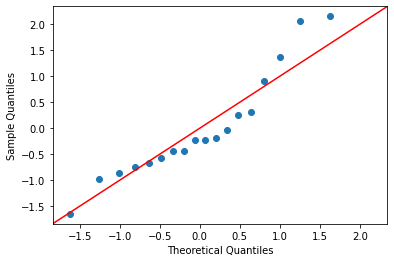

In [8]:
sm.qqplot(mergedDf[mergedDf['group'] == 1]['delay_time'], line='45',fit= True)
stats.shapiro(mergedDf[mergedDf['group'] == 1]['delay_time'])
# plt.hist(mergedDf[mergedDf['group'] == 1]['delay_time'])

In [9]:
diff1, diff2, diff3 = perform_tests(mergedDf) 

print('The time participants spent in bed each night:', diff1)
print('The number of nights participants delayed their bedtime:', diff2)
print('The mean time participants spent delaying their bedtime:', diff3)


The time participants spent in bed each night: no significant difference
The number of nights participants delayed their bedtime: no significant difference
The mean time participants spent delaying their bedtime: significant difference


## Ordinary Least Squares regression (5 points)

Also for this last question, you will use the dataframe ``mergedDf`` defined above. Use `statsmodels.api` to build a (OLS) regression model for `delay_time` on the predictors `age`, `bp_scale`, and  `chronotype` (in this order!). 

Return the coefficients and the conclusion on significance of the model. More specifically, into the variable `parameters` directly save the output of `*.params` applied to the model (without any rounding), and into the variable `conclusion` save the string 'significant' or 'not significant'.

\* Convince yourself that the basic diagnostics for this model are OK. Note that here you are not expected to explicitly check the diagnostics, but you will be in the final project.

In [10]:
def regression_analysis(mergedDf):
    X = np.column_stack((mergedDf['age'],mergedDf['bp_scale'],mergedDf['chronotype']))
    X = sm.add_constant(X)
    model = sm.OLS(mergedDf['delay_time'],X)
    results = model.fit()
    parameters = results.params
    
    # F test pvalue
    if results.f_pvalue < 0.05:
        conclusion = 'significant' 
    else:
        conclusion = 'not significant'
        
    return parameters,conclusion

In [11]:
parameters, conclusion = regression_analysis(mergedDf)

print('The parameters of the model are:')
print(parameters)
print('\nThe model is', conclusion)


The parameters of the model are:
const   -1399.595480
x1        -25.178161
x2        882.064704
x3         99.552661
dtype: float64

The model is significant


# Exercise 2: Feature engineering (15 points)

## Date one-hot encoding (5 points)
The dataframe below contains time-series data related to weather measurements from January - October 2020. In this exercise, you will extract date related features.

In [12]:
df = pd.read_csv('data/weather2020.csv')
df.head()

,Date,Unnamed: 0,Station,TAVG,Latitude,Longitude,Elevation,PRCP
0,2020-08-26,863598,RSM00027719,170.0,54.2330,37.6170,204.0,0.0
1,2020-03-12,261834,CA004014156,-71.0,51.4167,-105.2500,497.0,0.0
2,2020-01-21,74821,RSM00028224,-52.0,58.0167,56.3000,171.0,8.0
3,2020-05-09,470892,CA00703GDKB,-12.0,46.0833,-74.5500,239.0,0.0
4,2020-02-10,149342,SPW00014010,127.0,41.6667,-1.0333,263.0,0.0


In [13]:
def one_hot_date(df):
    """
    Infer the following information from the dataframe:
    - The weekday (e.g., Monday, Tuesday, etc.)
    - The week number (e.g., 'Week 1', 'Week 2', etc.)
    - The month (e.g., January, February, etc.)
    
    Return a new dataframe, which includes all original columns and all new one-hot encoded columns.
    
    Notes
    -----
    - Do not modify the original dataframe.
    - You only have to add columns for the weeks and months that are included in the dataset.
        e.g., "November" is not part of the data and thus doesn't need to be included.
    """
    
    new_df = df.copy()
    new_df['Date'] = pd.to_datetime(new_df['Date'])
    new_df['Weekday'] = new_df['Date'].dt.day_name().astype(str)
    new_df['Week number'] = 'Week ' + new_df['Date'].dt.isocalendar().week.astype(str)
    new_df['Month'] = new_df['Date'].dt.month_name().astype(str)
    
    # Get one hot encoding of columns B
    weekdays = pd.get_dummies(new_df['Weekday'])
    weeknum = pd.get_dummies(new_df['Week number'])
    month = pd.get_dummies(new_df['Month'])
    
    # Drop column B as it is now encoded
    new_df = new_df.drop(['Weekday', 'Week number', 'Month'],axis = 1)
    # Join the encoded df
    new_df = new_df.join(weekdays, how='inner').join(weeknum, how='inner').join(month, how='inner')
    
    return new_df

In [14]:
%time one_hot_date(df)

Wall time: 831 ms


,Date,Unnamed: 0,Station,TAVG,Latitude,Longitude,Elevation,PRCP,Friday,Monday,...,April,August,February,January,July,June,March,May,October,September
0,2020-08-26,863598,RSM00027719,170.0,54.2330,37.6170,204.0,0.0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,2020-03-12,261834,CA004014156,-71.0,51.4167,-105.2500,497.0,0.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2020-01-21,74821,RSM00028224,-52.0,58.0167,56.3000,171.0,8.0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,2020-05-09,470892,CA00703GDKB,-12.0,46.0833,-74.5500,239.0,0.0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2020-02-10,149342,SPW00014010,127.0,41.6667,-1.0333,263.0,0.0,0,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212852,2020-04-08,359708,FIE00146783,37.0,68.8489,28.3039,123.0,20.0,0,0,...,1,0,0,0,0,0,0,0,0,0
212853,2020-03-06,241960,SWM00002468,-32.0,56.8500,14.8300,199.0,0.0,1,0,...,0,0,0,0,0,0,1,0,0,0
212854,2020-05-12,481163,CA003014690,58.0,53.7167,-111.1167,580.0,0.0,0,0,...,0,0,0,0,0,0,0,1,0,0
212855,2020-05-25,529589,USS0011G30S,73.0,42.5200,-111.9600,2392.7,0.0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [15]:
oh = one_hot_date(df)
assert_equal(oh.loc[161231, ['Wednesday', 'Week 1', 'January']].values, [1, 1, 1])
assert_equal(oh.loc[161231, ['Monday', 'Week 2', 'February']].values, [0, 0, 0])
assert_equal(oh.loc[0, ['Wednesday', 'Week 35', 'August']].values, [1, 1, 1])
assert_equal(oh.loc[0, ['Monday', 'Week 36', 'September']].values, [0, 0, 0])


## Categorical one-hot encoding (5 points)

Below is a more recent version of movies table from the movielens data set. In contrast to the version from the previous assignment, the genres are not one-hot encoded in this more recent version. The goal is to one-hot encode these genres.

In [16]:
movies = pd.read_csv('data/movielens/movies.csv', index_col='movieId')
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


```
Movies Data File Structure (movies.csv)
---------------------------------------

Movie information is contained in the file `movies.csv`. Each line of this file after the header row represents one movie, and has the following format:

    movieId,title,genres

Movie titles are entered manually or imported from <https://www.themoviedb.org/>, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles.

Genres are a pipe-separated list.
```

In [17]:
def ohe_genres(movies):
    """
    Return a new dataframe, which includes all original columns and one-hot encoded genre columns.
    
    Notes
    -----
    - Do not modify the original dataframe.
    """
    movies_copy = movies.copy()
    movies_copy = movies_copy.join(movies_copy['genres'].str.get_dummies('|'), how='inner')
    
    return movies_copy

In [18]:
assert_equal(ohe_genres(movies).loc[1, ['Adventure', 'Animation', 'Children']].values, [1, 1, 1])
assert_equal(ohe_genres(movies).loc[2, ['Adventure', 'Animation', 'Children']].values, [1, 0, 1])
assert_equal(ohe_genres(movies).loc[193581, ['Thriller', 'War', 'Western']].values, [0, 0, 0])


## Custom features
For this question, we use the new version of the movielens ratings table.

In [19]:
ratings = pd.read_csv('data/movielens/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [20]:
def custom_features(df, funcs):
    """
    Return a dataframe with custom features using the passed-in funcs. 
    
    The name of each new column feature should be the function call with column name as argument.
    For example, 'log(userId)'. Hint: You can use f.__name__ to get the name of a function.
    
    Notes
    -----
    - The original dataframe should also be included. 
    - Do not modify the original dataframe.
    """
    ratings_copy = df.copy()

    for i in funcs:
        ndf = ratings.apply(i)
        ndf.columns = [i.__name__ + '(' + x +')' for x in ndf.columns]
        ratings_copy = ratings_copy.join(ndf, how = 'inner')
    
    return ratings_copy

In [21]:
custom_features(ratings, [np.log, np.cos])

,userId,movieId,rating,timestamp,log(userId),log(movieId),log(rating),log(timestamp),cos(userId),cos(movieId),cos(rating),cos(timestamp)
0,1,1,4.0,964982703,0.000000,0.000000,1.386294,20.687621,0.540302,0.540302,-0.653644,0.422204
1,1,3,4.0,964981247,0.000000,1.098612,1.386294,20.687619,0.540302,-0.989992,-0.653644,-0.953039
2,1,6,4.0,964982224,0.000000,1.791759,1.386294,20.687620,0.540302,0.960170,-0.653644,0.941752
3,1,47,5.0,964983815,0.000000,3.850148,1.609438,20.687622,0.540302,-0.992335,0.283662,0.530910
4,1,50,5.0,964982931,0.000000,3.912023,1.609438,20.687621,0.540302,0.964966,0.283662,-0.979799
...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,6.413459,12.022955,1.386294,21.124621,0.862288,-0.252991,-0.653644,-0.838313
100832,610,168248,5.0,1493850091,6.413459,12.033194,1.609438,21.124623,0.862288,-0.999985,0.283662,0.181653
100833,610,168250,5.0,1494273047,6.413459,12.033206,1.609438,21.124906,0.862288,0.421085,0.283662,0.056757
100834,610,168252,5.0,1493846352,6.413459,12.033218,1.609438,21.124620,0.862288,0.649519,0.283662,0.634537


In [22]:
result = custom_features(ratings, [np.log, np.cos])

assert('userId' in result.columns)
assert('log(userId)' in result.columns)
assert('cos(userId)' in result.columns)
assert_almost_equal(result.loc[0, ['userId', 'log(userId)', 'cos(userId)']], [1, 0, 0.540302], 2)


# Exercise 3: Classification SPAM vs. HAM (35 points)

The goal of this exercise is to build a classifier that is able to recognize spam email. "Ham" is e-mail that is not spam. The email data is provided in the following dataframe:

In [121]:
df = pd.read_csv('data/spamham.csv', sep='{', index_col=0).dropna()
df.head()

,text,class
data/spamham/lokay-m/tw_commercial_group/1701,Happy New Year Gang!\n\n\n\nHere is a draft fo...,ham
data/spamham/BG/2005/03/1111094580.25911_7.txt,----PJDPMV.YNLGEUXDFUJ\n\nContent-Type: text/p...,spam
data/spamham/BG/2004/08/1093039901.5282_162.txt,"<html>\n\n<body>\n\n<center>\n\n<font face=""ve...",spam
data/spamham/GP/part10/msg1932.eml,"<html>\n\n<body>\n\n<div align=3D""center""><br>...",spam
data/spamham/kaminski-v/personal/101,"Samer,\n\n\n\nI am glad this problem has been ...",ham


The data is quite simple. The `text` column contains the email content and `class` contains the corresponding labels, i.e., whether the email is `spam` or `ham`. In the following, we will use the variables `X` and `y` to denote the text features matrix and target vector, respectively.

In [122]:
X = df['text'].values
y = df['class'].values

## Warm-up exercises (15 points)
The following five exercises are warm-up exercises to get you started with building a simple Naive Bayes classifier.

### Count vectorizer (3 points)
Recall from the notebook `05.05 Naive Bayes Classifier` that we can extract features from text by counting the frequency of words for each piece of text.

In [123]:
from sklearn.feature_extraction.text import CountVectorizer

def make_counts(X):
    """
    Use CountVectorizer from sklearn to concert the dataset to a matrix of token counts.
    Return the extracted features.
    """
    vec = CountVectorizer()
    count = vec.fit_transform(X)
    return count

In [124]:
counts = make_counts(X)
assert_equal(counts[0, :].toarray().sum(), 34)


### Multinomial Naive Bayes (3 points)
Now that we have a `counts` features matrix, we can use this to train a Naive Bayes model.

In [125]:
from sklearn.naive_bayes import MultinomialNB

def nb_spamham(counts, y):
    """
    Return a fitted a Multinomial Naive-Bayes model.
    """
    
    model = MultinomialNB()
    return model.fit(counts,y)

In [126]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(X)
model = nb_spamham(counts, y)

examples = ['Free Amazon gift card! Click here!', "I'm going to attend the Linux users group tomorrow."]
example_counts = count_vectorizer.transform(examples)
predicted = model.predict(example_counts)

assert_equal(predicted, ['spam', 'ham'])


### Pipelining (3 points)
The previous series of steps can be connected together into one object which you train and then use to make predictions - this is called *pipelining*. Pipelining simplifies things a lot when you start tweaking your model to improve your results.

In [127]:
from sklearn.pipeline import make_pipeline
def pipeline_spamham(X, y):
    """
    Use `sklearn.pipeline.make_pipeline` and return a pipeline in which:
    - CountVectorizer is used to create the features matrix,
    - Multinomial Naive Bayes is used as prediction model.
    
    Make sure to return the fitted pipeline.
    """
    model = make_pipeline(CountVectorizer(), MultinomialNB())
    
    return model.fit(X,y)

In [128]:
pipeline = pipeline_spamham(X, y)

# Note that we do not need to use CountVectorized.transform here on the examples, because the pipeline takes care of that.
examples = ["Free Amazon gift card! Click here!", "I'm going to attend the Linux users group tomorrow."]
predicted = pipeline.predict(examples)

assert_equal(predicted, ['spam', 'ham'])


### Metrics: F1-score and confusion matrix (3 points)

Next, we need to get some real performance metrics to evaluate whether or ont our model predicts well. In binary classification, the [*F-score*](https://en.wikipedia.org/wiki/F-score) is a measure of a test's accuracy. The [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is closely related, which is a specific table layout that allows visualization of the classification performance. The next function will ask to compute both.

In [129]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def metrics(y, predicted):
    """
    Return the F1 score and the confusion matrix.
    """
    f1 = f1_score(y, predicted, pos_label='spam')
    matrix = confusion_matrix(y, predicted, labels=['ham', 'spam'])
    
    return f1, matrix

In [130]:
predicted = pipeline.predict(X)
f1, confusion = metrics(y, predicted)
print(f1)
print(confusion)

assert_almost_equal(f1, 0.942, 2)
assert_equal(confusion[0, 0], 7541)


0.9419986688219073
[[7541   57]
 [1163 9907]]


### Cross-validate (3 points)
So far, we have trained on the entire data set and evaluated our model on the same data. This is of course problematic because it surely will lead to overfitting. To solve this issue, we need to separate our data in testing and holdout sets. In this exercise, we will perform k-fold cross-validation.

In [131]:
from sklearn.model_selection import KFold

def cv_spamham(X, y, k=2):
    """
    Perform k-fold cross-validation using sklearn.model_selection.KFold,
    where k is an input parameter. 
    
    Return the average F1 score and the sum of confusion matrix over all test/holdout sets.
    """  
    kf = KFold(n_splits=k)
    conf_matrix_list = []
    f1_list = []
    
#     predict = cross_val_predict(pipeline,X,y,cv=kf)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        pipeline = pipeline_spamham(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        f1, conf_matrix = metrics(y_test, y_pred)
        f1_list.append(f1)
        conf_matrix_list.append(conf_matrix)

    return np.mean(f1_list), np.sum(conf_matrix_list, axis=0)

In [132]:
f1, confusion = cv_spamham(X[:1000], y[:1000], 2)
print(f1)
print(confusion)

assert_almost_equal(f1, 0.919, 3)
assert_equal(confusion[0, 0], 389)


0.9186652371009913
[[389   4]
 [ 87 520]]


This ends the warm-up exercise. A quick summary of what we did:
- We implemented a simple Multinomial Naive-Bayes model;
- We computed the F1-score and confusion matrices to evaluate our model; and
- We used cross-validation to evaluate our model.

Some things that we have not covered but may be interesting for the next exercise where you build your own model:
- Different ways of tokenzing the texts
- Hyperparamater tuning of MultinomialNB
- Using a different classification model

## Best model (20 points)

The final goal is to implement any model of your choice. 
- You are free to choose any model, including random forests, support vector machines, etc. 
- Your model will be evaluated on a hidden test that is not included in the given data set, but shares the same characteristics. Therefore, if you want to obtain a high score on this hidden test set, you have to make sure to follow the best practices in validating your model (i.e., train, validation and test set) to prevent underfitting and overfitting.
- Your score is determined based on the F1 score on the hidden test set. To get non-zero points, your model should perform better than the simple model we created above. To get the maximum number of points, your model should get a F1-score of at least **97.5%** on the hidden test.
- The training of your model should take no longer than **45 seconds**.

In [162]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

def best_spamham(X, y):
    """
    Implement your best performing model. Return a fitted model.
    """
    model = make_pipeline(TfidfVectorizer(), LogisticRegression(C=9, solver='saga', penalty = 'l2'))
    
    return model.fit(X,y)

# Pipeline(steps=[('vectorizer', TfidfVectorizer()),
#                 ('nb', MultinomialNB(alpha=0.5))])

In [157]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline

kf = KFold(n_splits=2)
a = np.linspace(0.1,1,10)
C = np.linspace(1,10,10)

spamham_pipe = Pipeline([('vectorizer', TfidfVectorizer()),
                       ('logis', LogisticRegression())])
spamham_param = {'logis__C':C,
                'logis__penalty': ['l1','l2','elasticnet'],
                'logis__solver': ['newton-cg', 'liblinear', 'sag', 'saga']}

tune = GridSearchCV(spamham_pipe,spamham_param,cv=kf, scoring=make_scorer(f1_score, pos_label = 'spam'))

tune.fit(X,y).best_estimator_

C:\Users\PC\Python\envs\python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\PC\Python\envs\python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\PC\Python\envs\python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\PC\Python\envs\python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\PC\Python\envs\python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\PC\Python\envs\python37\lib\site-pac

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('logis', LogisticRegression(C=9.0, solver='saga'))])

In [163]:
# No test available; the code shows how your model will be evaluated
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import time

t0 = time.perf_counter()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best = best_spamham(X_train, y_train)
predicted = best.predict(X_test)
t1 = time.perf_counter()
print(f'Your model took {t1-t0:.4} seconds to be trained.\n')

# The F1 score will be used to evaluate your score
f1_score(y_test, predicted, pos_label='spam')


Your model took 7.311 seconds to be trained.



0.9948557369715947

# Exercise 4: Regression on Californian house prices (35 points)

The goal of this exercise to apply regression to predict house prices in California. Here is a brief description of the data set:

```
California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bureau publishes sample data (a block group typically has a population
of 600 to 3,000 people).

An household is a group of people residing within a home. Since the average
number of rooms and bedrooms in this dataset are provided per household, these
columns may take surpinsingly large values for block groups with few households
and many empty houses, such as vacation resorts.
```

Here is the dataframe of the housing prices.

In [166]:
housing = pd.read_csv('data/house_prices.csv', index_col=0)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
13646,1.9234,43.0,4.821023,1.099432,1181.0,3.355114,34.08,-117.31,0.746
163,3.2250,46.0,4.326640,1.117805,1373.0,1.838019,37.81,-122.25,2.188
18240,2.5208,52.0,3.908163,1.035714,448.0,2.285714,37.40,-122.08,3.167
12061,5.1929,27.0,6.424460,1.032374,939.0,3.377698,33.87,-117.57,1.650
14177,3.0446,32.0,4.895075,1.002141,1741.0,3.728051,32.72,-117.08,1.019


`X` contains the features and `y` contains the target values.

In [167]:
X = housing.drop(['MedHouseVal'], axis=1).values
y = housing['MedHouseVal'].values

## Warm-up questions (15 points)

The following five exercises are warm-up exercises to get you started with building a simple linear regression model. This simple model will sometimes produce questionable results (e.g., negative house prices), but you can ignore that for now.

### Naive Linear Regression (3 points)

As a first warm-up, fit a linear model to describe the relationship between the housing price and all available features.


In [168]:
def nlr_prices(X, y):
    """
    Return a fitted a naive Linear Regression model using the input features directly.
    """
    from sklearn.linear_model import LinearRegression
    model = LinearRegression(fit_intercept=True)
    return model.fit(X,y)

In [169]:
nlr = nlr_prices(X, y)
predicted = nlr.predict(X)
result = predicted[0]
print(result)

assert_almost_equal(result, 1.093, 3) 


1.0933058685091055


### Metrics: Root Mean Squared Error (3 points)
We'll use the [root mean squared error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) as metric for predicting the house prices.

In [170]:
def rmse(target, predicted):
    """
    Return the root mean squared error between the target and predicted vector.
    """
    from sklearn.metrics import mean_squared_error

    return mean_squared_error(target, predicted, squared=False)

In [171]:
# Introduce train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

nlr = nlr_prices(X_train, y_train)

predicted = nlr.predict(X_test)
result = rmse(y_test, predicted)
print("RMSE:", result)

assert_almost_equal(result, 0.727, 3)


RMSE: 0.7273901601185822


### Adding polynomial features (3 points)
We can often get even higher accuracy by simply adding more features. Let's add some polynomial features and also make a pipeline.

In [172]:
def plr_prices(X, y, d=2):
    """
    Return a fitted linear regression model with polynomial features, where d is an input integer
    denoting the degree of the polynomials. Use sklearn.pipeline.make_pipeline to create a pipeline.
    """
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression
    poly_model = make_pipeline(PolynomialFeatures(d,include_bias=False),
                           LinearRegression(fit_intercept=True))
    return poly_model.fit(X,y)

In [173]:
plr = plr_prices(X_train, y_train, 2)

predicted = plr.predict(X_test)
result = rmse(y_test, predicted)
print("RMSE:", result)

assert_almost_equal(result, 1.884, 3)


RMSE: 1.8844998713604615


### Ridge (3 points)
The added polynomial features did not improve the model at all! Another step can often improve the model is to apply regularization, which constraints the magnitude of coefficients are constrained. For example, let's take a quick look at the coefficients obtained for our previous model:

In [174]:
pd.DataFrame(plr.named_steps['linearregression'].coef_).describe()

,0
count,44.000000
mean,-0.377836
std,5.689527
min,-32.293341
25%,-0.015442
50%,0.000057
75%,0.050075
max,8.900398


Here it can be seen that the majority of the coefficients are valued in the range of 0.01-0.03, but there are some coefficients with several orders of magnitude (-30.95, 8.42) as well. This means that our model is likely to ovefit on data that have high numbers for the features corresponding to these high coefficients. We will use [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) in this exercise as regularization. Moreover, another issue that our data set has is that features have different units (e.g., population size vs. average bedrooms). It's best to re-scale the data so that all features are affected similarly by the regularization strength, this can be done using `StandardScaler`, which renormalized each feature column to have zero mean and 1 standard deviation.

In [175]:
def ridge_prices(X, y, d=2, alpha=1):
    """
    Return a fitted linear regression model with polynomial features and L2 regularization, a.k.a Ridge. 
    d and alpha are the degree of the polynomial functions and the regularization factor, respectively.
    Add a StandardScaler to the pipeline after applying the PolynomialFeatures step.
    """
    from sklearn.linear_model import Ridge
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.preprocessing import StandardScaler

    regu_scaled_model = make_pipeline(PolynomialFeatures(d,include_bias=False),
                                      StandardScaler(),
                                      Ridge(alpha))

    return regu_scaled_model.fit(X,y)

In [176]:
ridge = ridge_prices(X_train, y_train, 2, 0.01)

predicted = ridge.predict(X_test)
result = rmse(y_test, predicted)
print("RMSE:", result)

assert_almost_equal(result, 0.672, 3)


RMSE: 0.6721336086335997


### Fine tuning the regularization parameter (3 points)
The final step in this warm-up exercise is to fine-tune the regularization parameter. We have used `alpha=0.01` as regularization parameter in the previous exercise by simple hand-tuning, but there may be other coefficients that lead to better predictions. Therefore, we should include a search of the hyperparamter `alpha`. When optimizing over hyperparameters, we need to include cross-validation as well to prevent overfitting. We'll make use of `GridSearchCV` (see lecture notebook `05.03: Hyperparameters and model validation`).

In [177]:
def best_ridge_prices(X, y, d=2, alphas=[0.1], cv=5):
    """
    Return a fitted linear regression model with polynomial features, feature scaling, 
    and L2 regularization (Ridge). Use GridSearchCV for searching for the best parameter
    (only for the regularization parameter). 
    
    Params
    ------
    d: int
        the degree of the polynomial features
    alphas: list[float]
        the alpha parameters to try out
    cv: int
        the number of cross-validation folds, which should be passed to GridSearchCV
    """
    from sklearn.linear_model import Ridge
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import GridSearchCV
    
    pipe = Pipeline([('poly', PolynomialFeatures(d,include_bias=False)),
                    ('scaler', StandardScaler()),
                    ('ridge', Ridge())])
    param = {'ridge__alpha':alphas}
    
    best_model = GridSearchCV(pipe,param, cv=cv)
    
    return best_model.fit(X,y)


In [178]:
best_ridge = best_ridge_prices(X_train, y_train, alphas=np.logspace(-1, 10, 100)).best_estimator_
print("Best alpha:", best_ridge.named_steps['ridge'].get_params()['alpha'])

predicted = best_ridge.predict(X_test)
result = rmse(y_test, predicted)
print("RMSE:", result)

assert_almost_equal(result, 0.846, 3)


Best alpha: 35938.13663804626
RMSE: 0.8460730735731928


Note that the `rmse` is quite a bit higher than before. This is because our first 4 steps did not include cross-validation. 

This concludes the warm-up exercise. In summary:
- We created simple linear regression model;
- We added polynomial features to the above;
- We implemented a Ridge model and used cross-validation to find the best alpha parameter.

Suggestions for the next exercise:
- Different models, e.g., random forest regression, Lasso, etc.
- Better feature engineering

## Best model (20 points)
The final goal is to implement any model of your choice. 
- You are free to choose any model for this exercise.
- Your model will be evaluated on a hidden test that is not included in the given data set, but shares the same characteristics. Therefore, to ensure a high score on this hidden test set, you should make sure to follow the best practices in validating your model (i.e., train, validation and test set) to avoid underfitting and overfitting.
- Your score is determined based on the RMSE score evaluated on the hidden test set. To get non-zero points, your model should perform better than the simple model we created above. To get the maximum number of points, your model should get an score of at least an RMSE of 0.6 on the hidden test.
- The training of your model should take no longer than **45 seconds**.

In [189]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

def best_model(X, y):
    """
    Implement and return your best performing model.
    """
    model = make_pipeline(PolynomialFeatures(degree = 2),
                         StandardScaler(),
                         RandomForestRegressor(n_estimators=30, max_depth=20))
    
    return model.fit(X,y)

# Best parameter (CV score=-0.586):
# {'mlp__alpha': 0.0026389473684210528}

# RandomForest
# Your model took 76.16 seconds to be trained.
# RMSE: 0.5233090846756641

# RandomForestRegressor(n_estimators=20, max_depth=10)
# Your model took 10.77 seconds to be trained.
# RMSE: 0.5487015226421296

# RandomForestRegressor(n_estimators=20, max_depth=15)
# Your model took 11.48 seconds to be trained.
# RMSE: 0.5358478431879755

# RandomForestRegressor(n_estimators=30, max_depth=20)
# Your model took 22.85 seconds to be trained.
# RMSE: 0.5225372999606611

In [102]:
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pf = PolynomialFeatures(degree = 2)
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
rfr = RandomForestRegressor()
pipe = Pipeline([("pf", pf), ("scaler", scaler), ("rfr", rfr)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    "rfr__n_estimators": np.linspace(1,20,20, dtype=int),
    "rfr__max_depth": [5,10,15,20],
    "rfr__criterion": ['squared_error']
}
search = GridSearchCV(pipe, param_grid, scoring='neg_root_mean_squared_error', cv=3)
search.fit(X_train,y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=-0.552):
{'rfr__criterion': 'squared_error', 'rfr__max_depth': 15, 'rfr__n_estimators': 20}


In [190]:
# No test available; the code shows how your model will be evaluated
import time

t0 = time.perf_counter()
best = best_model(X_train, y_train)
predicted = best.predict(X_test)
t1 = time.perf_counter()
print(f'Your model took {t1-t0:.4} seconds to be trained.\n')

# The RMSE will be used to evaluate your score
result = rmse(y_test, predicted)
print("RMSE:", result)


Your model took 13.32 seconds to be trained.

RMSE: 0.5229864254730847
